<a href="https://colab.research.google.com/github/HwangJae-won/Hands-on-machine-learning/blob/main/2.%20End-to-end%20machine%20leanrning%20project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

`update 211024`
파이프라인 부분 다시 보기

# California Housing Prices modeling

# 1.  사용 데이터 및 문제 정의 

## 1. 사용 데이터 
- 캘리포니아 주택 가격(California Housing Prices) 데이터셋: 1990년 캘리포니아 인구조사 데이터를 기반으로 만들어진 데이터

- 캘리포니아의 블록 그룹(block group)마다 인구(population), 중간 소득(median income), 중간 주택 가격(median housing price)

- 데이터에 대한 세부 설명: https://developers.google.com/machine-learning/crash-course/california-housing-data-description?hl=ko  

## 2. 문제 정의
캘리포니아 주택 가격 데이터셋을 가지고 학습시켜 다른 데이터가 주어졌을 때 구역의 주택 가격의 median을 예측하는 모델 만들기 

- 데이터 확인해보았을 때 가격이라는 label 존재 : supervised learning
- 가격 예측 : regression


## 3. 성능 측정 지표 
MSE 사용

# 2. set up option & DATA loading

In [ ]:
import os
import pandas as pd
import numpy as np


#시각화 옵션
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
#차트 기본 크기 설정
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# 한글출력
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

In [ ]:
# 이미지 저장 루트
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True) #이미지 디렉토리 생성
os.listdir() #디렉토리 확인

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [ ]:
#동시 출력 가능 코드 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

# 경고 무시
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Load the data

In [ ]:
import tarfile
import urllib.request #인터넷에서 데이터 불러오는 모듈

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz" #데이터 다운로드됨

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [ ]:
fetch_housing_data()

In [ ]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
housing = load_housing_data()
housing.head(3)
#median_house_value: 예측하고자하는 주택 가격의 median

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [ ]:
#data 기본 정보 확인하기 
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
#numerical data
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [ ]:
#categorical data
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

- missing value in 'total_bedrooms'   
- dtype of 'ocean_proximity' is object: maybe it need one-hot encoding

# 3. EDA 

자세한 EDA 진행하기 전에 test set 분리해두기: 데이터 스누핑 방지 (test set으로 EDA 진행하면 overfitting되는 모델 선택할 수도 있음)

## 1. split data



`simple split`
- indices 지정하여 직접 나누기 
- ID에 기반하여 나누기 
- sklearn의 spilt 함수 사용하기 

In [ ]:
#indices 지정하여 직접 나누기
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

# sklearn의 spilt 함수 사용하기
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)


# ID에 기반하여 나누기
from zlib import crc32
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

`stratification split:계층적 샘플링`

- 표본의 수가 충분하지 않을 경우 편향 발생 가능
- Train/Test set이 각 데이터를 대표할 수 있도록 고르게 샘플링 되기 위해서 사용, 전체 모수를 계층으로 나눠 각 계층마다 샘플링을 하는 방법
- 모집단의 데이터 분포 비율을 유지하면서 데이터를 샘플링

캘리포니아 주택 가격 데이터 셋에서 전문가가 주택 가격의 median을 예측하는데에 소득의 median이 영향을 준다고 이야기했다고 가정:이를 기준으로 계층적 샘플링 진행 (분석을 위해 데이터에 대한 사전 조사가 필요한 이유!)

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


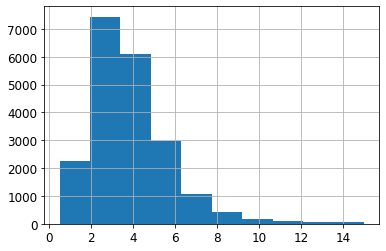

In [ ]:
housing['median_income'].hist();

In [ ]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

계층적 샘플링을 위해서는 계층별로 충분한 수의 샘플 필요. 현재 구간별 데이터 수의 차이가 심하므로 pd.cut(동일 길이로 나누어 범주 만들기 )

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

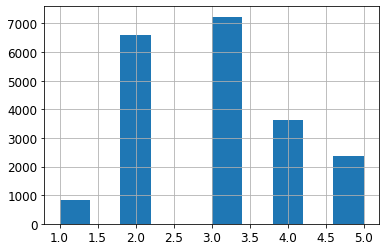

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"],
                             
                            bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5]) #5개의 카테고리를 가진 소득 카테고리 특성 생성
housing["income_cat"].value_counts()/ len(housing)

#구간 나눠진 것 확인
housing["income_cat"].hist()

In [ ]:
#계층적 샘플링
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=43)


for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [ ]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039890,0.040213,0.973236,0.162206
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350614,0.358527,2.266446,0.009213
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


In [ ]:
#분석에 필요없는 열 삭제 #income_cat은 계층별 비율 확인하기 위해 추가해준 열
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

strat_test_set.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
5057,-118.35,34.02,27.0,3358.0,1069.0,2415.0,956.0,1.4589,87500.0,<1H OCEAN
6954,-118.06,33.98,40.0,1410.0,255.0,932.0,273.0,4.2206,178000.0,<1H OCEAN
16876,-122.40,37.60,30.0,5351.0,1134.0,2558.0,1074.0,3.5817,369300.0,NEAR OCEAN


## 2. data exploration & visualization

### 1. 데이터 구조 확인

In [ ]:
housing = strat_train_set.copy()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4e586d6b90>,
      dtype=object)

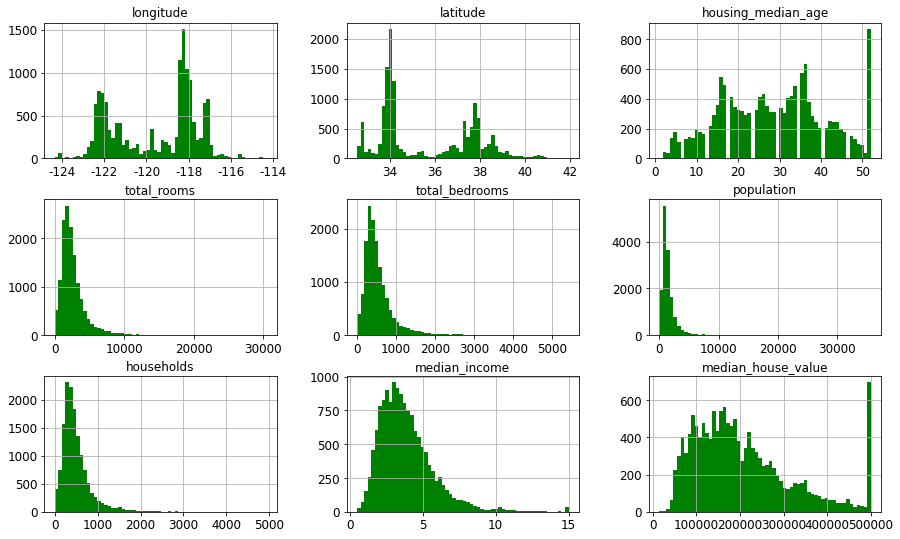

In [ ]:
housing.hist(bins=60, figsize=(15, 9), color="green"); plt.show()

확인할 수 있는 점

- 다른 특성과 달리 median_income 은 스케일링되어 있음 
- housing_median_age와 housing_median_value은 outlier 존재 : 분석 위해 제거해줄 필요 있음.
- 특성들의 단위가 다름: 스케일링 필요


### 2. 지리적 데이터 시각화

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend

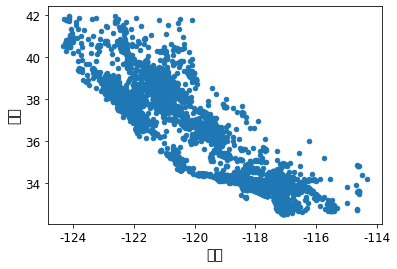

In [ ]:
ax = housing.plot(kind='scatter', x='longitude', y='latitude')
ax.set(xlabel='경도', ylabel='위도');

특별한 인사이트 없음

[Text(0, 0.5, 'latitude'), Text(0.5, 0, 'longitude')]

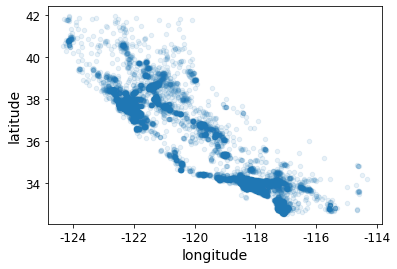

In [ ]:
#밀집된 영역 보이기
ax = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
ax.set(xlabel='longitude', ylabel='latitude')

[Text(0, 0.5, '위도'), Text(0.5, 0, '경도')]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text

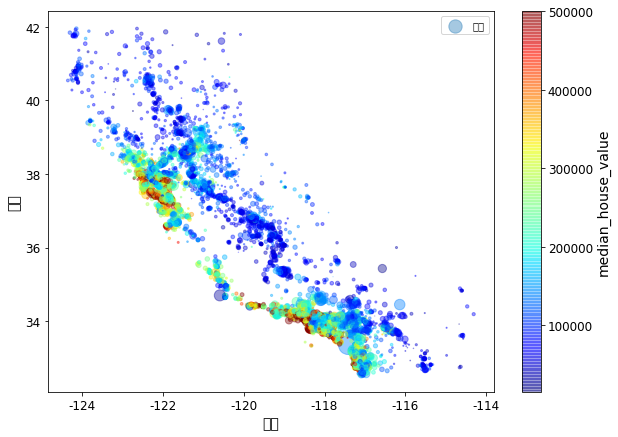

In [ ]:
#주택 가격 나타내기 
ax = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=strat_train_set["population"]/100, label="인구", figsize=(10,7), #원 반지름 #구역의 인구
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, #가격
    sharex=False)
ax.set(xlabel='경도', ylabel='위도')
plt.legend()

- 해안 지역에 주택 가격 높게 책정
- 인구 밀도 높을수록 주택 가격 높음

In [ ]:
# 캘리포니아 지도 이미지 다운로드
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x7f4e57a649d0>)

Text(0, 0.5, 'Latitude')

Text(0.5, 0, 'Longitude')

[Text(1, 0, '$15k'),
 Text(1, 0, '$63k'),
 Text(1, 0, '$112k'),
 Text(1, 0, '$160k'),
 Text(1, 0, '$209k'),
 Text(1, 0, '$258k'),
 Text(1, 0, '$306k'),
 Text(1, 0, '$355k'),
 Text(1, 0, '$403k'),
 Text(1, 0, '$452k'),
 Text(1, 0, '$500k')]

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


Saving figure california_housing_prices_plot


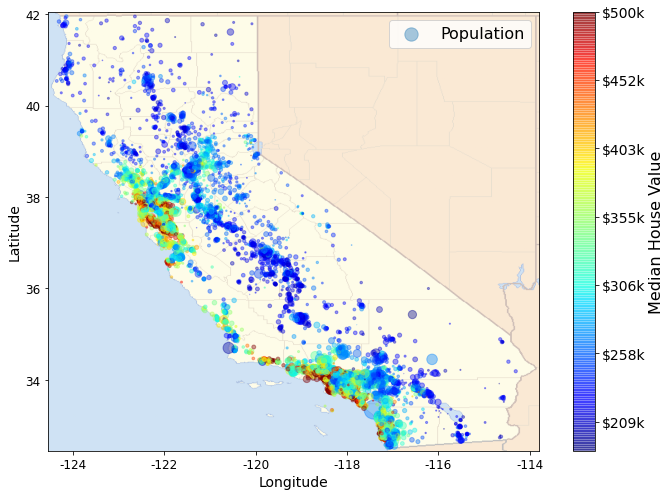

In [ ]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

### 3. 상관 관계 확인

In [ ]:
#피어슨 상관 계수
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687575
total_rooms           0.138843
housing_median_age    0.102678
households            0.069685
total_bedrooms        0.052633
population           -0.020705
longitude            -0.042065
latitude             -0.146978
Name: median_house_value, dtype: float64

시각적으로 확인

' Function to plot correlation of features '

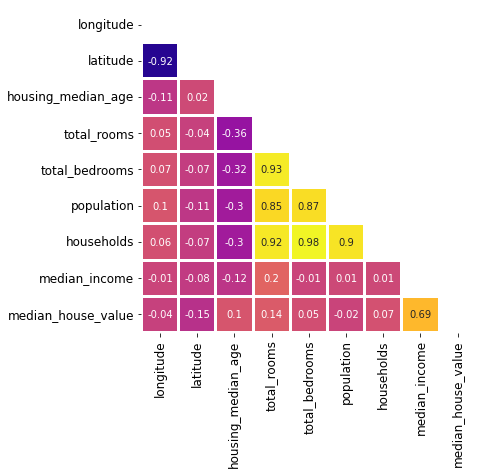

In [ ]:
''' Function to plot correlation of features '''
def corrMat(df,id=False):
    
    corr_mat = df.corr().round(2)
    f, ax = plt.subplots(figsize=(6,6))
    mask = np.zeros_like(corr_mat,dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr_mat,mask=mask,vmin=-1,vmax=1,center=0, 
                cmap='plasma',square=False,lw=2,annot=True,cbar=False);plt.show()

corrMat(housing)

Target variable median_house_value is very mildly correlated to all but one feature here: median_income.

`so "median income" might outline this as an important feature.`

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4e57db3290>,
      dtype=object)

Saving figure scatter_matrix_plot


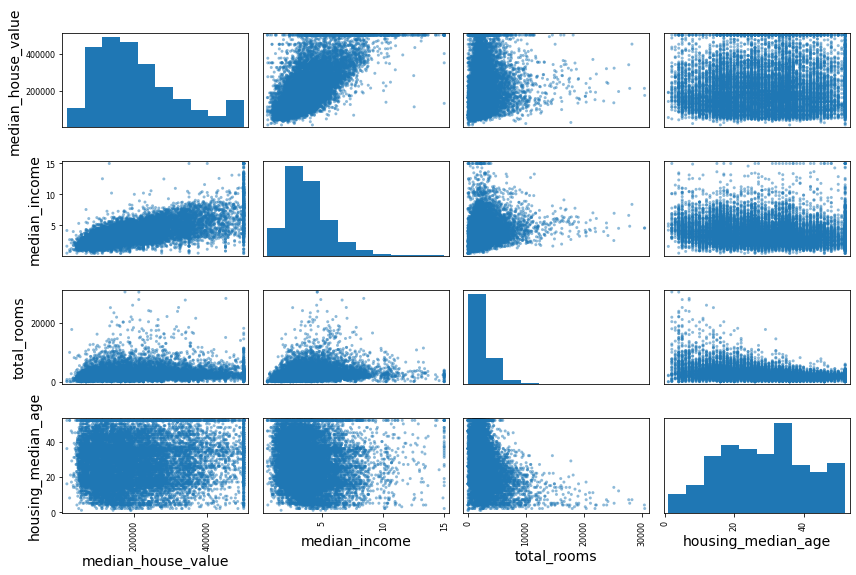

In [ ]:
#상관 관계 높은 top3개의 변수에 대하여 plot
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8));
save_fig("scatter_matrix_plot")

(0.0, 16.0, 0.0, 550000.0)

Saving figure income_vs_house_value_scatterplot


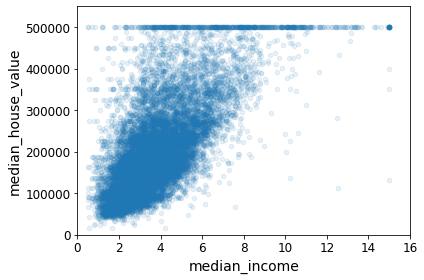

In [ ]:
#가장 큰 상관관계를 보인 median_housing_value와 median_income 간 plot
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000]);
save_fig("income_vs_house_value_scatterplot")

# 4. data 전처리 및 Feature engineering


### variable combination

In [ ]:
#단순 방의 개수는 유의 x #가구당 방의 개수
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
#마찬가지로 단순 침실 개수도 유의하지 않을 것
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
#가구당 인원
housing['population_per_household'] = housing['population'] / housing['households']

housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
16227,-121.32,37.97,43.0,2453.0,490.0,1093.0,438.0,2.9107,88800.0,INLAND,5.600457,0.199755,2.495434
11779,-121.28,38.77,6.0,3819.0,550.0,1738.0,587.0,5.8718,201400.0,INLAND,6.505963,0.144017,2.960818
3292,-122.70,39.00,18.0,793.0,148.0,186.0,59.0,2.3125,162500.0,INLAND,13.440678,0.186633,3.152542
651,-122.13,37.72,45.0,2315.0,451.0,1006.0,444.0,3.5240,186200.0,NEAR BAY,5.213964,0.194816,2.265766
18613,-122.05,37.05,41.0,2422.0,502.0,915.0,366.0,4.1679,201300.0,NEAR OCEAN,6.617486,0.207267,2.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11852,-120.48,39.78,11.0,513.0,104.0,204.0,86.0,2.3750,100000.0,INLAND,5.965116,0.202729,2.372093
6302,-117.98,34.03,21.0,797.0,162.0,484.0,166.0,2.6250,191100.0,<1H OCEAN,4.801205,0.203262,2.915663
19019,-121.96,38.36,11.0,3208.0,790.0,1772.0,694.0,2.7434,218800.0,INLAND,4.622478,0.246259,2.553314
15870,-122.41,37.76,52.0,492.0,139.0,316.0,168.0,3.0865,225000.0,NEAR BAY,2.928571,0.282520,1.880952


In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687575
rooms_per_household         0.152224
total_rooms                 0.138843
housing_median_age          0.102678
households                  0.069685
total_bedrooms              0.052633
population                 -0.020705
population_per_household   -0.022312
longitude                  -0.042065
latitude                   -0.146978
bedrooms_per_room          -0.255386
Name: median_house_value, dtype: float64

(0.0, 5.0, 0.0, 520000.0)

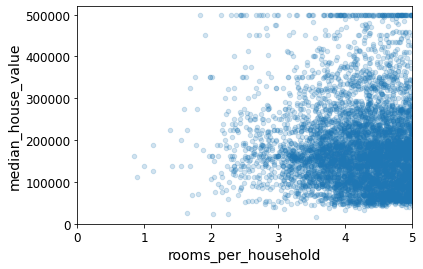

In [ ]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

### missing value imputation
- 결측치 있는 열 전체 삭제 
- 결측치 행만 삭제 
- some value로 채우기 (zero, mean, median etc.)
- sklearn imputer

total bedroom에 결측치 있었음 (numerical)

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [ ]:
#total_bedroom에 결측치 있는 임의의 데이터셋
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17825,-121.88,37.40,9.0,6751.0,NaN,4240.0,1438.0,5.3400,<1H OCEAN
7316,-118.19,33.98,36.0,4179.0,NaN,4582.0,1196.0,2.0087,<1H OCEAN
11441,-117.98,33.73,18.0,3833.0,NaN,2192.0,996.0,3.4679,<1H OCEAN
13925,-114.59,34.83,41.0,812.0,NaN,375.0,158.0,1.7083,INLAND
19818,-119.30,36.57,32.0,728.0,NaN,461.0,149.0,3.0156,INLAND


In [ ]:
# 결측치 있는 열 전체 삭제
sample_incomplete_rows.dropna(subset=["total_bedrooms"])  

# 결측치 행만 삭제
sample_incomplete_rows.drop("total_bedrooms", axis=1) 

# some value로 채우기 (zero, mean, median etc.)
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)

# sklearn imputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median") #median 값으로 채우기 
housing_num = housing.drop("ocean_proximity", axis=1) #categorical data에는 적용해주 수 없으므로 빼주기
imputer.fit(housing_num)
#trainsform the traing set
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17825,-121.88,37.40,9.0,6751.0,437.0,4240.0,1438.0,5.3400,<1H OCEAN
7316,-118.19,33.98,36.0,4179.0,437.0,4582.0,1196.0,2.0087,<1H OCEAN
11441,-117.98,33.73,18.0,3833.0,437.0,2192.0,996.0,3.4679,<1H OCEAN
13925,-114.59,34.83,41.0,812.0,437.0,375.0,158.0,1.7083,INLAND
19818,-119.30,36.57,32.0,728.0,437.0,461.0,149.0,3.0156,INLAND


,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
17825,-121.88,37.40,9.0,6751.0,4240.0,1438.0,5.3400,<1H OCEAN
7316,-118.19,33.98,36.0,4179.0,4582.0,1196.0,2.0087,<1H OCEAN
11441,-117.98,33.73,18.0,3833.0,2192.0,996.0,3.4679,<1H OCEAN
13925,-114.59,34.83,41.0,812.0,375.0,158.0,1.7083,INLAND
19818,-119.30,36.57,32.0,728.0,461.0,149.0,3.0156,INLAND


SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17825,-121.88,37.40,9.0,6751.0,437.0,4240.0,1438.0,5.3400
7316,-118.19,33.98,36.0,4179.0,437.0,4582.0,1196.0,2.0087
11441,-117.98,33.73,18.0,3833.0,437.0,2192.0,996.0,3.4679
13925,-114.59,34.83,41.0,812.0,437.0,375.0,158.0,1.7083
19818,-119.30,36.57,32.0,728.0,437.0,461.0,149.0,3.0156


In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
16227,-121.32,37.97,43.0,2453.0,490.0,1093.0,438.0,2.9107
11779,-121.28,38.77,6.0,3819.0,550.0,1738.0,587.0,5.8718
3292,-122.70,39.00,18.0,793.0,148.0,186.0,59.0,2.3125
651,-122.13,37.72,45.0,2315.0,451.0,1006.0,444.0,3.5240
18613,-122.05,37.05,41.0,2422.0,502.0,915.0,366.0,4.1679


### categorical data 처리  
- ordinalencoder
- one- hot encoding

In [ ]:
#categorical data: ocean_proximity
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
16227,INLAND
11779,INLAND
3292,INLAND
651,NEAR BAY
18613,NEAR OCEAN
3561,<1H OCEAN
1724,NEAR BAY
8219,NEAR OCEAN
15261,NEAR OCEAN
5607,<1H OCEAN


In [ ]:
#ordinal
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]
ordinal_encoder.categories_

array([[1.],
       [1.],
       [1.],
       [3.],
       [4.],
       [0.],
       [3.],
       [4.],
       [4.],
       [0.]])

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot
#default: sparse array로 출력됨
#sparse=False: 처음부터 dense array로 출력

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.]])

### custome transformer
sclaing도 포함

*pipeline 구축 과정 다시 공부 필요

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [ ]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
16227,-121.32,37.97,43,2453,490,1093,438,2.9107,INLAND,5.60046,2.49543
11779,-121.28,38.77,6,3819,550,1738,587,5.8718,INLAND,6.50596,2.96082
3292,-122.7,39,18,793,148,186,59,2.3125,INLAND,13.4407,3.15254
651,-122.13,37.72,45,2315,451,1006,444,3.524,NEAR BAY,5.21396,2.26577
18613,-122.05,37.05,41,2422,502,915,366,4.1679,NEAR OCEAN,6.61749,2.5


In [ ]:
#pipeline 구축
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
housing_num_tr

array([[-0.88040804,  1.10416354,  1.14707677, ...,  0.06953657,
        -0.04983156, -0.21289968],
       [-0.86040105,  1.4797038 , -1.79470505, ...,  0.42857638,
        -0.01181049, -1.0400224 ],
       [-1.57064899,  1.58767163, -0.84061365, ...,  3.17824249,
         0.00385309, -0.40762641],
       ...,
       [-1.20051978,  1.28723942, -1.39716697, ..., -0.31823906,
        -0.04510283,  0.47718662],
       [-1.42559835,  1.00558423,  1.86264532, ..., -0.98988573,
        -0.10003363,  1.01527426],
       [ 0.34001799, -0.67965268, -1.0791365 , ...,  0.37375942,
        -0.04597808, -1.65488304]])

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [ ]:
housing_prepared

array([[-0.88040804,  1.10416354,  1.14707677, ...,  0.        ,
         0.        ,  0.        ],
       [-0.86040105,  1.4797038 , -1.79470505, ...,  0.        ,
         0.        ,  0.        ],
       [-1.57064899,  1.58767163, -0.84061365, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.20051978,  1.28723942, -1.39716697, ...,  0.        ,
         0.        ,  0.        ],
       [-1.42559835,  1.00558423,  1.86264532, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.34001799, -0.67965268, -1.0791365 , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
housing_prepared.shape

(14448, 16)

For reference, here is the old solution based on a `DataFrameSelector` transformer (to just select a subset of the Pandas `DataFrame` columns), and a `FeatureUnion`:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Now let's join all these components into a big pipeline that will preprocess both the numerical and the categorical features:

In [ ]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [ ]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [ ]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

array([[-0.88040804,  1.10416354,  1.14707677, ...,  0.        ,
         0.        ,  0.        ],
       [-0.86040105,  1.4797038 , -1.79470505, ...,  0.        ,
         0.        ,  0.        ],
       [-1.57064899,  1.58767163, -0.84061365, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.20051978,  1.28723942, -1.39716697, ...,  0.        ,
         0.        ,  0.        ],
       [-1.42559835,  1.00558423,  1.86264532, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.34001799, -0.67965268, -1.0791365 , ...,  0.        ,
         0.        ,  0.        ]])

The result is the same as with the `ColumnTransformer`:

In [ ]:
np.allclose(housing_prepared, old_housing_prepared)

True

# 5. model selection &training

## 1. linear regression

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [148616.16564925 191075.68655018 113997.89079337 239731.04446127
 285176.860815  ]


In [ ]:
print("Labels:", list(some_labels))

Labels: [88800.0, 201400.0, 162500.0, 186200.0, 201300.0]


In [ ]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print('RMSE :', lin_rmse)

RMSE : 68462.46390642202


In [ ]:
#MAE 확인
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49576.46930326428

mse가 너무 크다-> underfitting: 더 복잡한 모델 시도

`K-fold cross validation` :모델 검증

In [ ]:
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준편차:", scores.std())

In [ ]:
#fine-tune the model 
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

점수: [65752.07486746 70623.54067614 74154.27933884 67161.11797114
 70241.93539732 71462.66484286 67827.11914932 66372.11393769
 67531.6924566  67312.35416454]
평균: 68843.88928019158
표준편차: 2525.5080846812903


## 2. Decisinotree regression



In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print('RMSE :', tree_rmse)

RMSE : 0.0


In [ ]:
# DecisionTree
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

점수: [71052.89088434 70223.88941034 69938.96763473 70229.71150569
 72588.18480719 75342.8074697  67058.36981298 70770.42328211
 69772.95675921 70501.05051898]
평균: 70747.92520852883
표준편차: 2010.3459785164341


## 3. Randomforest regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)


housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
#Randomforest regression
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

점수: [49088.675816   49731.93044139 50884.95891476 51244.68212325
 49600.872828   54650.5767251  48369.19415468 49989.17438933
 51250.94638884 50292.58159832]
평균: 50510.35933796758
표준편차: 1634.8508959755668


In [ ]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     68843.889280
std       2662.119266
min      65752.074867
25%      67198.927019
50%      67679.405803
75%      70528.139356
max      74154.279339
dtype: float64

## 4. SVR (support vector regression)

In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

111237.28760430438

## 5. hyperparameter search
- Gridsearch
- randomizedsearch: used when parameter space is large

시간 오래 소요됨

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

In [ ]:
#best hyperparameter
grid_search.best_params_
grid_search.best_estimator_

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
pd.DataFrame(grid_search.cv_results_)
#gridsearch result

## 6. 모델 평가

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

참고 
- Hands-on machine learing
- https://www.kaggle.com/shtrausslearning/house-price-prediction-using-bayesian-regression